Загружаем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
import pickle
import os
warnings.filterwarnings('ignore')

Выбор и описание датасета

2.1. ВЫБОР И ОПИСАНИЕ ДАТАСЕТА
Размер датасета: (6611, 13)

Первые 5 строк датасета:
   movie_id        name_rus  kp_rating  movie_duration  kp_rating_count  \
0     10000        Иезавель      7.411             104            518.0   
1     10005  Живем один раз      7.168              86            330.0   
2     10033           Исход      6.599             208            193.0   
3     10055       Бумеранг!      6.906              88            153.0   
4    100552       Крик совы      6.395              91            640.0   

   movie_year  imdb_rating  imdb_rating_count  \
0        1938          7.6             8585.0   
1        1937          7.4             3812.0   
2        1960          6.8             6618.0   
3        1947          7.3             2680.0   
4        2006          5.6             6147.0   

                            genres countries       budget  critics_rating  \
0                 драма, мелодрама       США   $1 250 000            94.0   
1      фильм-ну

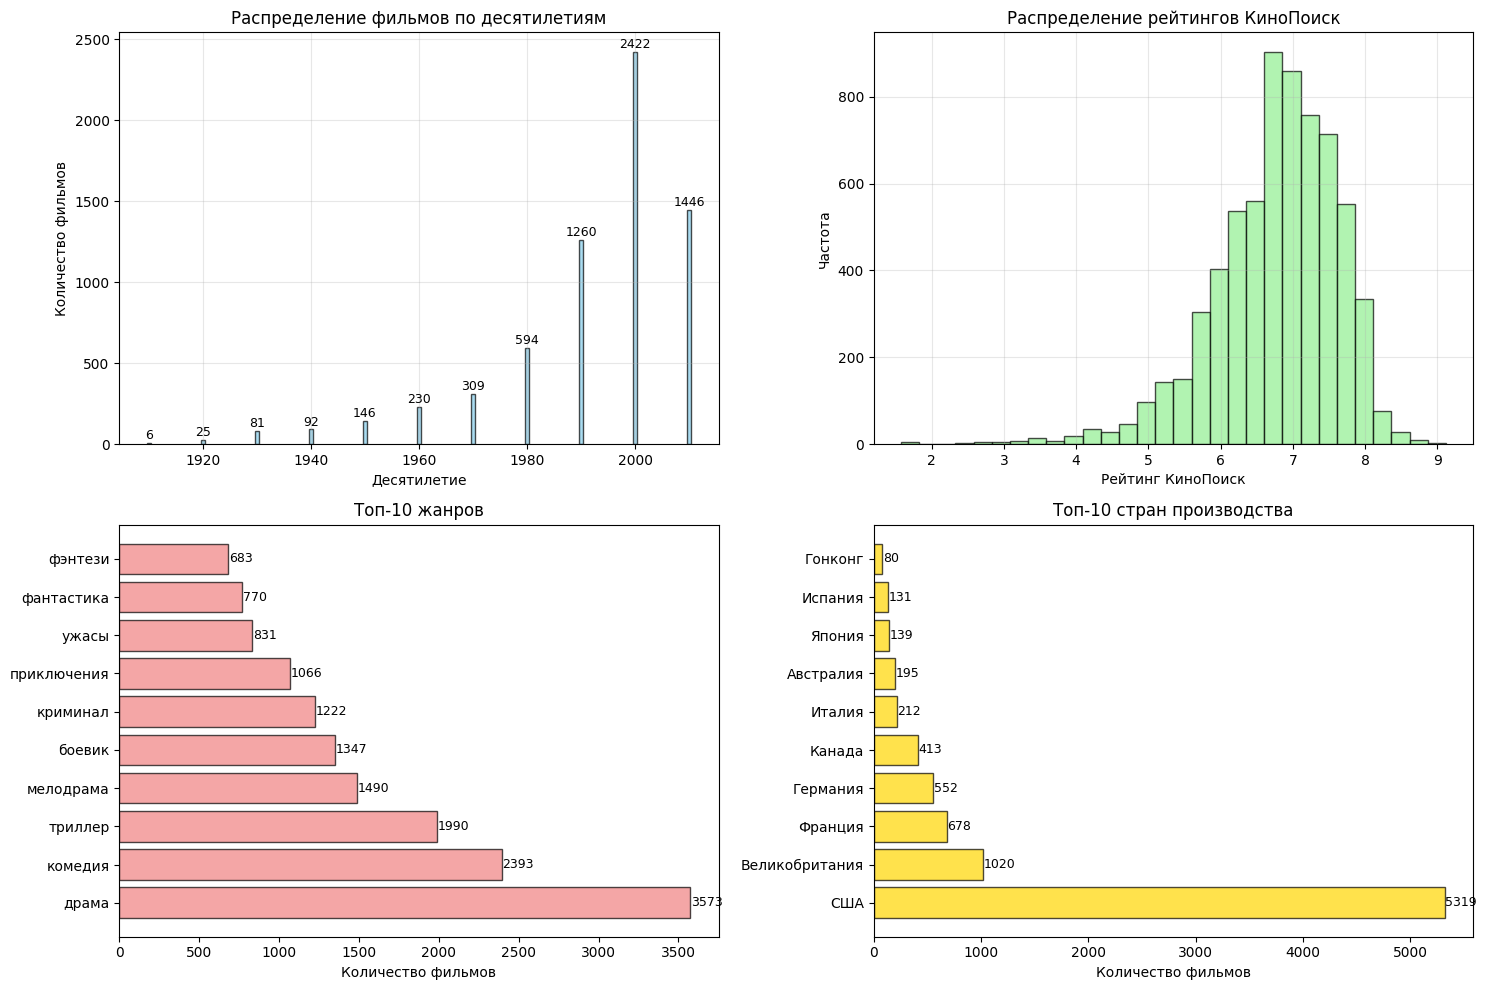

In [2]:
print("=" * 60)
print("2.1. ВЫБОР И ОПИСАНИЕ ДАТАСЕТА")
print("=" * 60)

# Загрузка данных
df = pd.read_csv('kp_all_movies_cleanedd.csv')
print(f"Размер датасета: {df.shape}")

# Базовый анализ данных
print("\nПервые 5 строк датасета:")
print(df.head())

print("\nИнформация о структуре данных:")
print(df.info())

print("\nСтатистическое описание числовых признаков:")
print(df.describe())

# Анализ временного периода
if 'movie_year' in df.columns:
    print(f"\nВременной период охвата: {df['movie_year'].min()} - {df['movie_year'].max()} гг.")
    print("Распределение по десятилетиям:")
    decade_counts = (df['movie_year'] // 10 * 10).value_counts().sort_index()
    for decade, count in decade_counts.items():
        print(f"  {decade}-е: {count} фильмов")

# Анализ рейтингов
if 'kp_rating' in df.columns:
    print(f"\nАнализ рейтингов КиноПоиск:")
    print(f"  Диапазон: {df['kp_rating'].min():.2f} - {df['kp_rating'].max():.2f}")
    print(f"  Среднее: {df['kp_rating'].mean():.2f} ± {df['kp_rating'].std():.2f}")
    print(f"  Медиана: {df['kp_rating'].median():.2f}")

# Визуализации для раздела 2.1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Диаграмма распределения фильмов по десятилетиям
if 'movie_year' in df.columns:
    df_decade = (df['movie_year'] // 10 * 10).value_counts().sort_index()
    bars = axes[0,0].bar(df_decade.index, df_decade.values, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Десятилетие')
    axes[0,0].set_ylabel('Количество фильмов')
    axes[0,0].set_title('Распределение фильмов по десятилетиям')
    axes[0,0].grid(True, alpha=0.3)
    # Добавляем подписи значений
    for bar in bars:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 2. Распределение рейтингов КиноПоиск
if 'kp_rating' in df.columns:
    axes[0,1].hist(df['kp_rating'].dropna(), bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Рейтинг КиноПоиск')
    axes[0,1].set_ylabel('Частота')
    axes[0,1].set_title('Распределение рейтингов КиноПоиск')
    axes[0,1].grid(True, alpha=0.3)

# 3. Анализ жанров
if 'genres' in df.columns:
    all_genres = []
    for genres in df['genres'].dropna():
        if isinstance(genres, str):
            all_genres.extend([genre.strip() for genre in genres.split(',')])
    top_genres = pd.Series(all_genres).value_counts().head(10)
    bars = axes[1,0].barh(range(len(top_genres)), top_genres.values, color='lightcoral', alpha=0.7, edgecolor='black')
    axes[1,0].set_yticks(range(len(top_genres)))
    axes[1,0].set_yticklabels(top_genres.index)
    axes[1,0].set_xlabel('Количество фильмов')
    axes[1,0].set_title('Топ-10 жанров')
    # Добавляем подписи значений
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[1,0].text(width + 5, bar.get_y() + bar.get_height()/2.,
                      f'{int(width)}', ha='left', va='center', fontsize=9)

# 4. Анализ стран
if 'countries' in df.columns:
    all_countries = []
    for countries in df['countries'].dropna():
        if isinstance(countries, str):
            all_countries.extend([country.strip() for country in countries.split(',')])
    top_countries = pd.Series(all_countries).value_counts().head(10)
    bars = axes[1,1].barh(range(len(top_countries)), top_countries.values, color='gold', alpha=0.7, edgecolor='black')
    axes[1,1].set_yticks(range(len(top_countries)))
    axes[1,1].set_yticklabels(top_countries.index)
    axes[1,1].set_xlabel('Количество фильмов')
    axes[1,1].set_title('Топ-10 стран производства')
    # Добавляем подписи значений
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[1,1].text(width + 5, bar.get_y() + bar.get_height()/2.,
                      f'{int(width)}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Предобработка и разведочный анализ данных (EDA)


2.2. ПРЕДОБРАБОТКА И РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []
Пропущенных значений не обнаружено
Размер после обработки: (6611, 20)
Количество признаков: 20
Признаки: ['kp_rating', 'movie_duration', 'movie_year', 'imdb_rating', 'critics_rating', 'log_budget', 'genre_драма', 'genre_комедия', 'genre_боевик', 'genre_триллер', 'genre_мелодрама', 'genre_фантастика', 'genre_ужасы', 'country_США', 'country_Великобритания', 'country_Франция', 'country_Германия', 'has_critics_rating', 'log_kp_rating_count', 'log_imdb_rating_count']


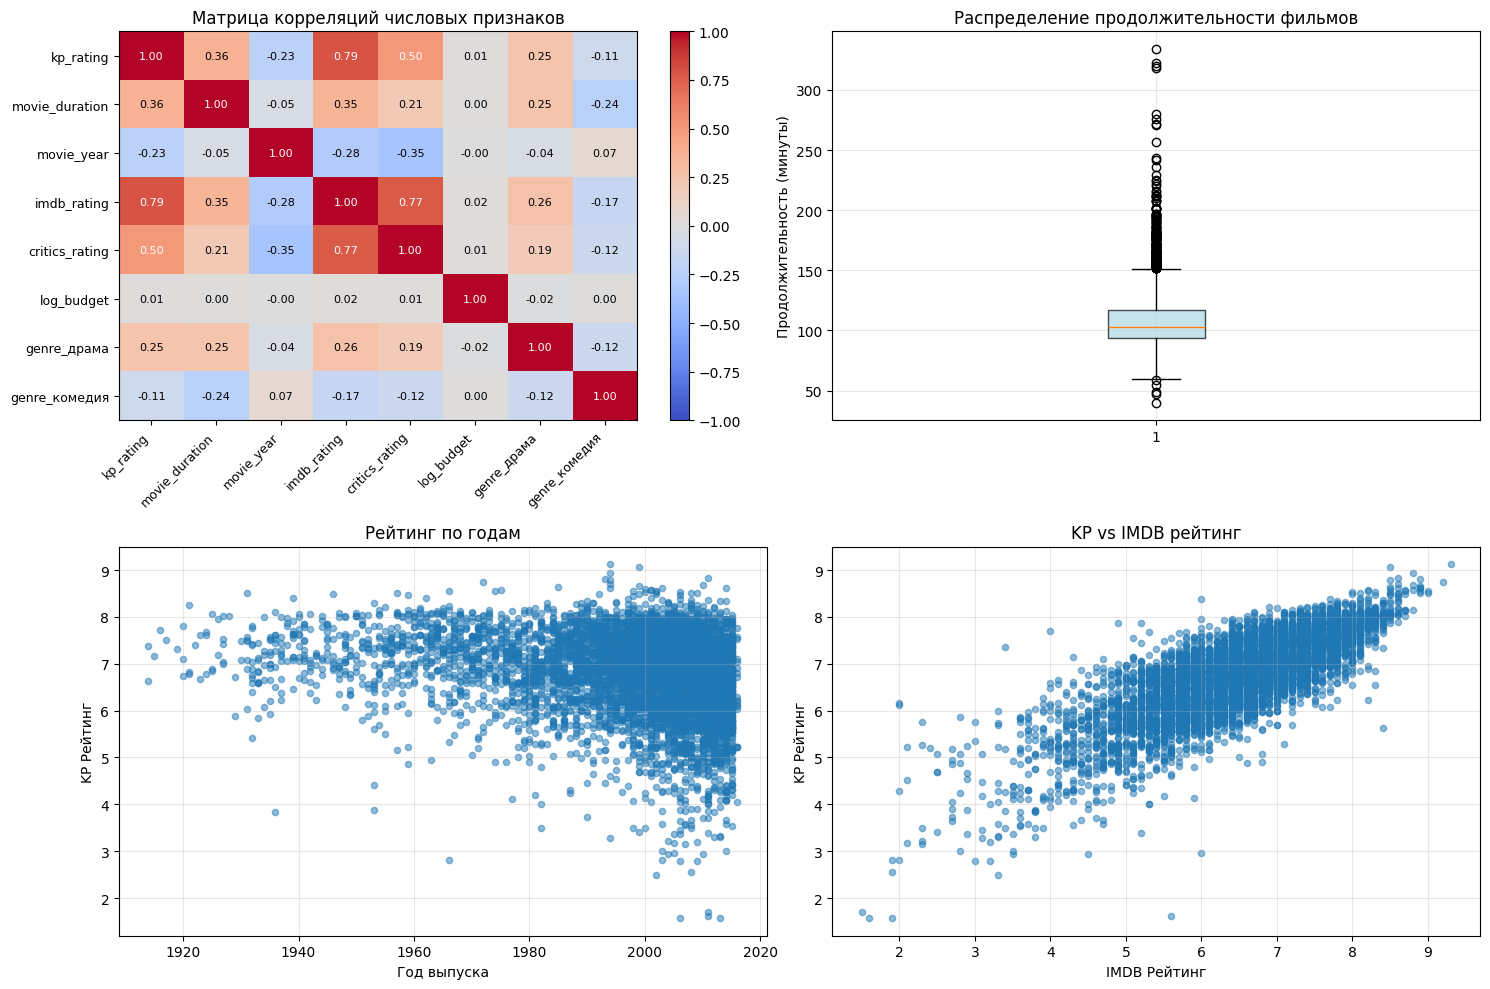

In [3]:
print("\n" + "=" * 60)
print("2.2. ПРЕДОБРАБОТКА И РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
print("=" * 60)

# Анализ пропущенных значений
print("\nАНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({
    'Количество пропусков': missing_data,
    'Процент пропусков': missing_percent
})
missing_info = missing_info[missing_info['Количество пропусков'] > 0]
print(missing_info)

# Визуализация пропущенных значений
if len(missing_info) > 0:
    plt.figure(figsize=(12, 6))
    missing_plot_data = missing_info.sort_values('Процент пропусков', ascending=False)
    bars = plt.bar(missing_plot_data.index, missing_plot_data['Процент пропусков'], 
                  color='salmon', alpha=0.7, edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Признаки')
    plt.ylabel('Процент пропусков (%)')
    plt.title('Распределение пропущенных значений по признакам')
    plt.grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Пропущенных значений не обнаружено")

# Улучшенная предобработка с меньшим количеством признаков
def preprocess_data_improved(df):
    df_clean = df.copy()
    
    # Базовые заполнения пропусков
    numeric_columns = ['kp_rating', 'movie_duration', 'kp_rating_count', 'movie_year', 
                     'imdb_rating', 'imdb_rating_count', 'critics_rating']
    
    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Упрощенная обработка бюджета
    def parse_budget_simple(budget_str):
        if pd.isna(budget_str):
            return np.nan
        try:
            budget_str = str(budget_str).replace(' ', '').replace('$', '').replace('€', '').replace('£', '')
            budget_str = budget_str.replace('¥', '').replace('INR', '').replace('CAD', '').replace('AUD', '')
            budget_str = budget_str.replace('млн', '').replace('million', '')
            return float(budget_str) * 1000000 if any(x in str(budget_str).lower() for x in ['млн', 'million']) else float(budget_str)
        except:
            return np.nan
    
    if 'budget' in df_clean.columns:
        df_clean['budget_parsed'] = df_clean['budget'].apply(parse_budget_simple)
        df_clean['budget_parsed'] = df_clean['budget_parsed'].fillna(df_clean['budget_parsed'].median())
        df_clean['log_budget'] = np.log1p(df_clean['budget_parsed'])
    
    # Основные жанры
    main_genres = ['драма', 'комедия', 'боевик', 'триллер', 'мелодрама', 'фантастика', 'ужасы']
    if 'genres' in df_clean.columns:
        for genre in main_genres:
            df_clean[f'genre_{genre}'] = df_clean['genres'].apply(
                lambda x: 1 if isinstance(x, str) and genre in x.lower() else 0
            )
    
    # Основные страны
    main_countries = ['США', 'Великобритания', 'Франция', 'Германия']
    if 'countries' in df_clean.columns:
        for country in main_countries:
            df_clean[f'country_{country}'] = df_clean['countries'].apply(
                lambda x: 1 if isinstance(x, str) and country in x else 0
            )
    
    # Производные признаки
    df_clean['has_critics_rating'] = (~df_clean['critics_rating'].isna()).astype(int)
    if 'kp_rating_count' in df_clean.columns:
        df_clean['log_kp_rating_count'] = np.log1p(df_clean['kp_rating_count'])
    if 'imdb_rating_count' in df_clean.columns:
        df_clean['log_imdb_rating_count'] = np.log1p(df_clean['imdb_rating_count'])
    
    # Удаляем исходные колонки с высокой кардинальностью
    columns_to_drop = ['name_rus', 'name_eng', 'genres', 'countries', 'budget', 
                      'movie_id', 'kp_rating_count', 'imdb_rating_count', 'budget_parsed']
    for col in columns_to_drop:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
    
    return df_clean

# Применение предобработки
df_processed = preprocess_data_improved(df)
print(f"Размер после обработки: {df_processed.shape}")
print(f"Количество признаков: {len(df_processed.columns)}")
print(f"Признаки: {list(df_processed.columns)}")

# EDA после предобработки
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Матрица корреляций
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
if len(numeric_columns) > 1:
    # Берем только первые 8 признаков для читаемости
    cols_to_plot = numeric_columns[:min(8, len(numeric_columns))]
    correlation_matrix = df_processed[cols_to_plot].corr()
    
    im = axes[0,0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[0,0].set_xticks(range(len(cols_to_plot)))
    axes[0,0].set_yticks(range(len(cols_to_plot)))
    axes[0,0].set_xticklabels([col[:15] + '...' if len(col) > 15 else col for col in cols_to_plot], 
                             rotation=45, ha='right', fontsize=9)
    axes[0,0].set_yticklabels([col[:15] + '...' if len(col) > 15 else col for col in cols_to_plot], 
                             fontsize=9)
    axes[0,0].set_title('Матрица корреляций числовых признаков')
    
    # Добавляем значения корреляции
    for i in range(len(cols_to_plot)):
        for j in range(len(cols_to_plot)):
            text_color = 'white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black'
            axes[0,0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                         ha="center", va="center", color=text_color, fontsize=8)
    
    plt.colorbar(im, ax=axes[0,0])

# 2. Box-plot продолжительности фильмов
if 'movie_duration' in df_processed.columns:
    data_to_plot = df_processed['movie_duration'].dropna()
    if len(data_to_plot) > 0:
        box_plot = axes[0,1].boxplot(data_to_plot, patch_artist=True)
        box_plot['boxes'][0].set_facecolor('lightblue')
        box_plot['boxes'][0].set_alpha(0.7)
        axes[0,1].set_ylabel('Продолжительность (минуты)')
        axes[0,1].set_title('Распределение продолжительности фильмов')
        axes[0,1].grid(True, alpha=0.3)

# 3. Scatter plot: год выпуска vs рейтинг
if 'movie_year' in df_processed.columns and 'kp_rating' in df_processed.columns:
    valid_data = df_processed[['movie_year', 'kp_rating']].dropna()
    if len(valid_data) > 0:
        axes[1,0].scatter(valid_data['movie_year'], valid_data['kp_rating'], alpha=0.5, s=20)
        axes[1,0].set_xlabel('Год выпуска')
        axes[1,0].set_ylabel('KP Рейтинг')
        axes[1,0].set_title('Рейтинг по годам')
        axes[1,0].grid(True, alpha=0.3)

# 4. Scatter plot: IMDB vs KP рейтинг
if 'imdb_rating' in df_processed.columns and 'kp_rating' in df_processed.columns:
    valid_data = df_processed[['imdb_rating', 'kp_rating']].dropna()
    if len(valid_data) > 0:
        axes[1,1].scatter(valid_data['imdb_rating'], valid_data['kp_rating'], alpha=0.5, s=20)
        axes[1,1].set_xlabel('IMDB Рейтинг')
        axes[1,1].set_ylabel('KP Рейтинг')
        axes[1,1].set_title('KP vs IMDB рейтинг')
        axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Выбор инструментов и архитектура системы


2.3-2.4. ВЫБОР ИНСТРУМЕНТОВ И АРХИТЕКТУРА СИСТЕМЫ

ВЫБРАННЫЕ ИНСТРУМЕНТЫ:
• Pandas, NumPy - обработка данных
• Scikit-learn - классические алгоритмы ML
• XGBoost - градиентный бустинг
• Matplotlib, Seaborn - визуализация

АРХИТЕКТУРА СИСТЕМЫ:
1. Загрузка и анализ данных
2. Предобработка и очистка
3. Feature engineering
4. Разделение на выборки
5. Масштабирование признаков
6. Обучение моделей
7. Валидация и оценка
8. Интерпретация результатов



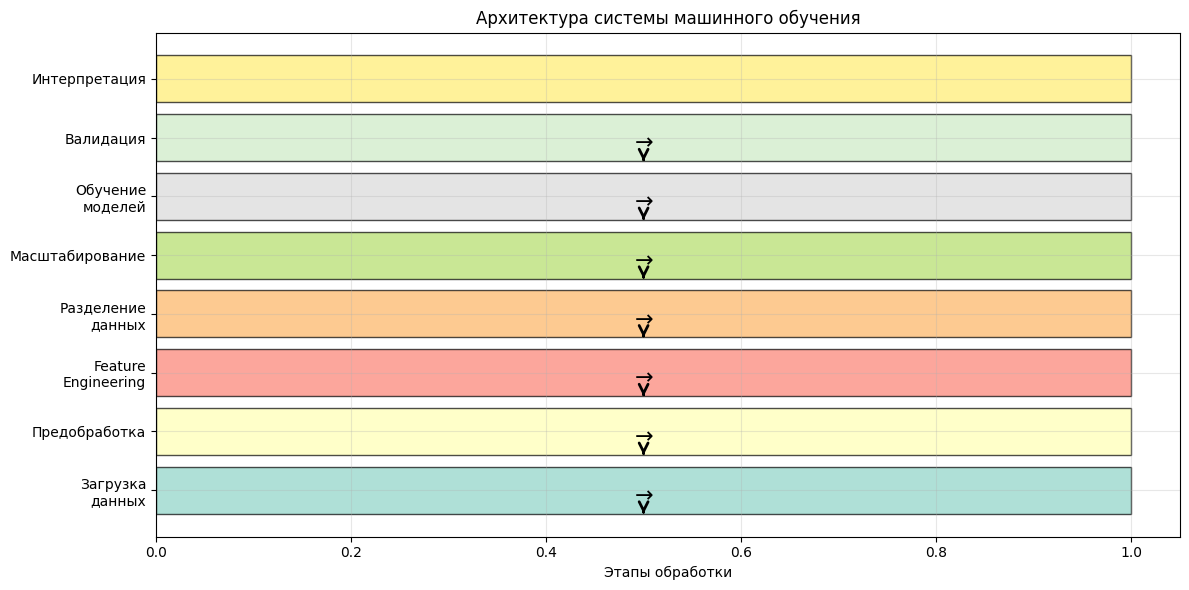

In [4]:
print("\n" + "=" * 60)
print("2.3-2.4. ВЫБОР ИНСТРУМЕНТОВ И АРХИТЕКТУРА СИСТЕМЫ")
print("=" * 60)

print("""
ВЫБРАННЫЕ ИНСТРУМЕНТЫ:
• Pandas, NumPy - обработка данных
• Scikit-learn - классические алгоритмы ML
• XGBoost - градиентный бустинг
• Matplotlib, Seaborn - визуализация

АРХИТЕКТУРА СИСТЕМЫ:
1. Загрузка и анализ данных
2. Предобработка и очистка
3. Feature engineering
4. Разделение на выборки
5. Масштабирование признаков
6. Обучение моделей
7. Валидация и оценка
8. Интерпретация результатов
""")

# Визуализация архитектуры
fig, ax = plt.subplots(figsize=(12, 6))
stages = ["Загрузка\nданных", "Предобработка", "Feature\nEngineering", 
          "Разделение\nданных", "Масштабирование", "Обучение\nмоделей", 
          "Валидация", "Интерпретация"]

y_pos = np.arange(len(stages))
colors = plt.cm.Set3(np.linspace(0, 1, len(stages)))

bars = ax.barh(y_pos, [1]*len(stages), color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(stages, fontsize=10)
ax.set_xlabel('Этапы обработки')
ax.set_title('Архитектура системы машинного обучения')
ax.grid(True, alpha=0.3)

# Добавляем стрелки
for i in range(len(stages)-1):
    ax.annotate('→', xy=(0.5, y_pos[i] - 0.4), xytext=(0.5, y_pos[i] - 0.1),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'),
                ha='center', va='center', fontsize=16, xycoords='data')

plt.tight_layout()
plt.show()

Реализация и обучение модели

In [5]:
print("\n" + "=" * 60)
print("2.5. РЕАЛИЗАЦИЯ И ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 60)

# Удаление высококоррелированных признаков
def remove_highly_correlated_features(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    if to_drop:
        print(f"Удаляем высококоррелированные признаки: {to_drop}")
        return df.drop(to_drop, axis=1)
    else:
        print("Высококоррелированных признаков не обнаружено")
        return df

df_processed = remove_highly_correlated_features(df_processed, threshold=0.8)
print(f"Размер после удаления коррелированных признаков: {df_processed.shape}")

# Подготовка данных
if 'kp_rating' not in df_processed.columns:
    raise ValueError("Целевая переменная 'kp_rating' не найдена в данных")

feature_columns = [col for col in df_processed.columns if col != 'kp_rating']
X = df_processed[feature_columns]
y = df_processed['kp_rating']

print(f"Финальное количество признаков: {len(feature_columns)}")
print(f"Размерность X: {X.shape}, y: {y.shape}")

# Проверка на наличие данных
if len(X) == 0 or len(y) == 0:
    raise ValueError("Нет данных для обучения")

# Разделение данных
try:
    y_bins = pd.cut(y, bins=min(5, len(y.unique())), labels=False)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_bins
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, 
        stratify=pd.cut(y_temp, bins=min(5, len(y_temp.unique())), labels=False)
    )
except ValueError as e:
    print(f"Ошибка при стратифицированном разделении: {e}")
    # Используем обычное разделение если стратификация не работает
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Валидационная выборка: {X_val.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Масштабирование
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Функция оценки модели
def evaluate_model_improved(model, X_train, X_val, y_train, y_val, model_name):
    """Расширенная оценка модели с акцентом на обнаружение переобучения"""
    
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=min(5, len(y_train)), scoring='r2')
    except:
        cv_scores = [0]  # Если кросс-валидация не работает
        
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    r2_gap = train_r2 - val_r2
    relative_overfit = (train_r2 - val_r2) / abs(train_r2) if train_r2 != 0 else 0
    
    results = {
        'model': model_name,
        'cv_r2_mean': np.mean(cv_scores),
        'cv_r2_std': np.std(cv_scores),
        'train_r2': train_r2,
        'val_r2': val_r2,
        'r2_gap': r2_gap,
        'relative_overfit': relative_overfit,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'is_overfit': relative_overfit > 0.3 and r2_gap > 0.1
    }
    
    return results, model

# Модели с регуляризацией
models_regularized = {
    'Ridge': Ridge(alpha=10.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42, max_iter=2000),
    'RandomForest': RandomForestRegressor(
        n_estimators=50,
        max_depth=8,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        min_samples_split=15,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        reg_alpha=1.0,
        reg_lambda=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

print("Обучение моделей с регуляризацией...")
results_list = []
trained_models = {}

for name, model in models_regularized.items():
    print(f"Обучение {name}...")
    try:
        results, trained_model = evaluate_model_improved(
            model, X_train_scaled, X_val_scaled, y_train, y_val, name
        )
        results_list.append(results)
        trained_models[name] = trained_model
        status = "⚠️ ПЕРЕОБУЧЕНА" if results['is_overfit'] else "✅ НОРМА"
        print(f"  {status} | Train R2: {results['train_r2']:.3f} | Val R2: {results['val_r2']:.3f}")
    except Exception as e:
        print(f"  ❌ Ошибка: {e}")


2.5. РЕАЛИЗАЦИЯ И ОБУЧЕНИЕ МОДЕЛИ
Удаляем высококоррелированные признаки: ['log_imdb_rating_count']
Размер после удаления коррелированных признаков: (6611, 19)
Финальное количество признаков: 18
Размерность X: (6611, 18), y: (6611,)
Тренировочная выборка: (3966, 18)
Валидационная выборка: (1322, 18)
Тестовая выборка: (1323, 18)
Обучение моделей с регуляризацией...
Обучение Ridge...
  ✅ НОРМА | Train R2: 0.732 | Val R2: 0.725
Обучение Lasso...
  ✅ НОРМА | Train R2: 0.000 | Val R2: -0.000
Обучение ElasticNet...
  ✅ НОРМА | Train R2: 0.363 | Val R2: 0.369
Обучение RandomForest...
  ✅ НОРМА | Train R2: 0.763 | Val R2: 0.719
Обучение GradientBoosting...
  ✅ НОРМА | Train R2: 0.830 | Val R2: 0.780
Обучение XGBoost...
  ✅ НОРМА | Train R2: 0.824 | Val R2: 0.780


Оценка качества модели


2.6. ОЦЕНКА КАЧЕСТВА МОДЕЛИ

РЕЗУЛЬТАТЫ МОДЕЛЕЙ:
              model  train_r2  val_r2  r2_gap  relative_overfit  is_overfit
0             Ridge    0.7320  0.7252  0.0068            0.0093       False
1             Lasso    0.0000 -0.0000  0.0000            0.0000       False
2        ElasticNet    0.3630  0.3694 -0.0064           -0.0177       False
3      RandomForest    0.7633  0.7185  0.0448            0.0586       False
4  GradientBoosting    0.8296  0.7803  0.0494            0.0595       False
5           XGBoost    0.8240  0.7803  0.0437            0.0530       False


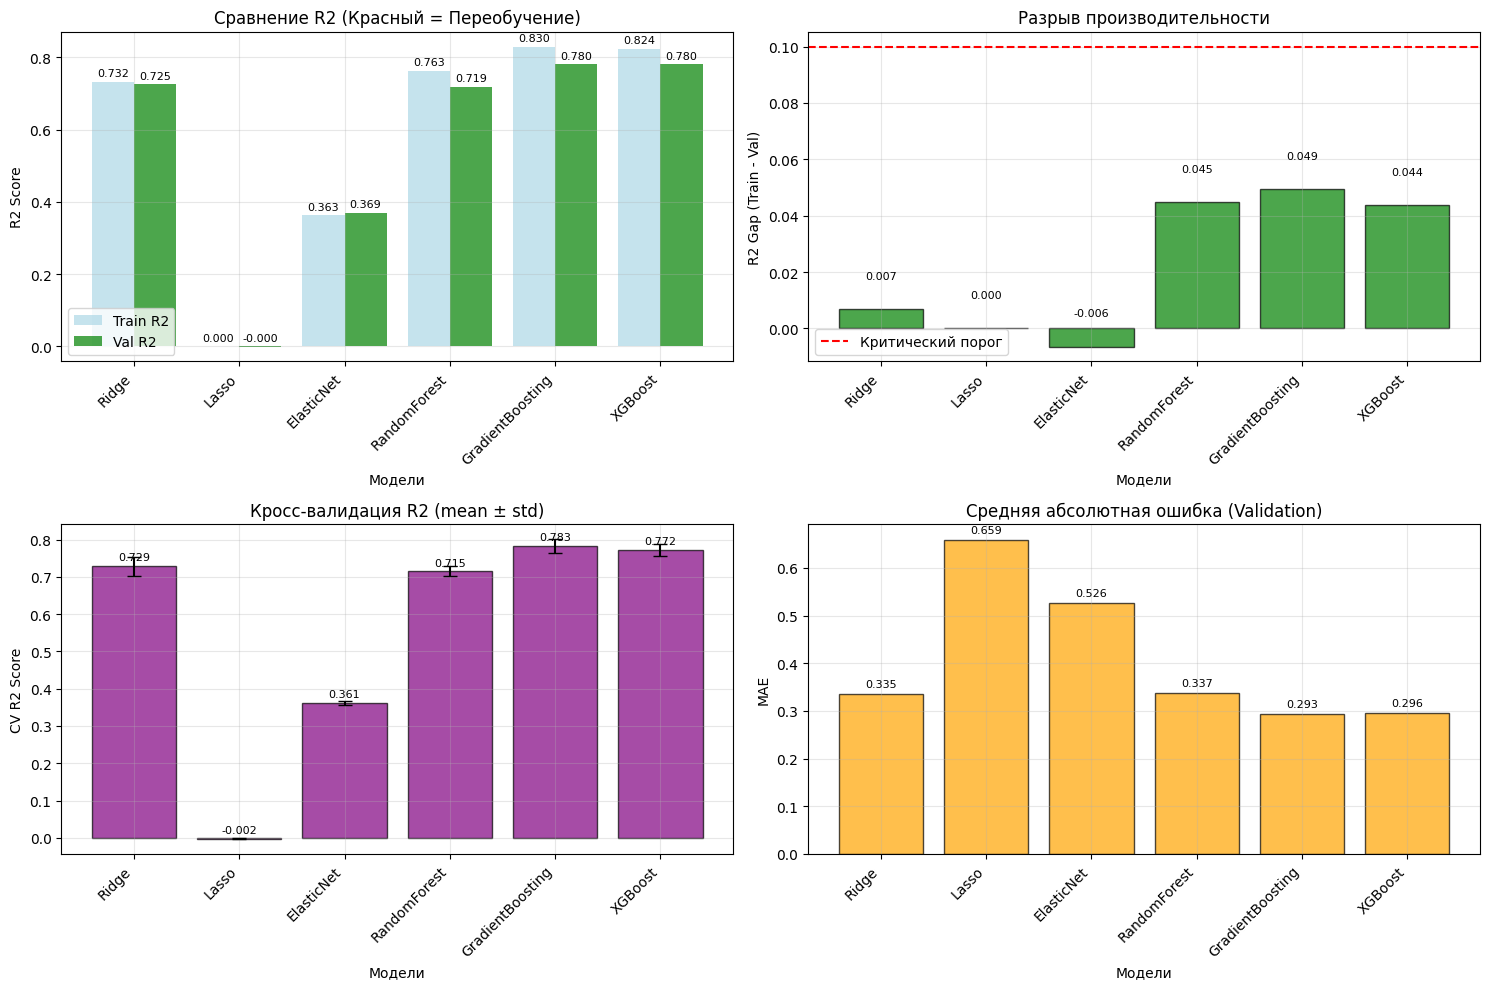


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ:
              model  test_r2  test_mae  test_rmse
0             Ridge   0.7323    0.3445     0.4550
1             Lasso  -0.0001    0.6741     0.8795
2        ElasticNet   0.3671    0.5356     0.6997
3      RandomForest   0.7242    0.3447     0.4618
4  GradientBoosting   0.7902    0.2971     0.4029
5           XGBoost   0.7891    0.2991     0.4039


In [6]:
print("\n" + "=" * 60)
print("2.6. ОЦЕНКА КАЧЕСТВА МОДЕЛИ")
print("=" * 60)

if not results_list:
    raise ValueError("Ни одна модель не была успешно обучена")

# Анализ результатов
results_df = pd.DataFrame(results_list)
print("\nРЕЗУЛЬТАТЫ МОДЕЛЕЙ:")
display_cols = ['model', 'train_r2', 'val_r2', 'r2_gap', 'relative_overfit', 'is_overfit']
print(results_df[display_cols].round(4))

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Сравнение R2
colors = ['red' if overfit else 'green' for overfit in results_df['is_overfit']]
x_pos = np.arange(len(results_df))

bars1 = axes[0,0].bar(x_pos - 0.2, results_df['train_r2'], 0.4, label='Train R2', alpha=0.7, color='lightblue')
bars2 = axes[0,0].bar(x_pos + 0.2, results_df['val_r2'], 0.4, label='Val R2', alpha=0.7, color=colors)
axes[0,0].set_xlabel('Модели')
axes[0,0].set_ylabel('R2 Score')
axes[0,0].set_title('Сравнение R2 (Красный = Переобучение)')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Gap анализ
bars = axes[0,1].bar(results_df['model'], results_df['r2_gap'], color=colors, alpha=0.7, edgecolor='black')
axes[0,1].axhline(y=0.1, color='red', linestyle='--', label='Критический порог')
axes[0,1].set_xlabel('Модели')
axes[0,1].set_ylabel('R2 Gap (Train - Val)')
axes[0,1].set_title('Разрыв производительности')
axes[0,1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Добавляем значения
for bar in bars:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Кросс-валидация
bars = axes[1,0].bar(results_df['model'], results_df['cv_r2_mean'], 
              yerr=results_df['cv_r2_std'], capsize=5, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_xlabel('Модели')
axes[1,0].set_ylabel('CV R2 Score')
axes[1,0].set_title('Кросс-валидация R2 (mean ± std)')
axes[1,0].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3)

# Добавляем значения
for bar in bars:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 4. Сравнение MAE
bars = axes[1,1].bar(results_df['model'], results_df['val_mae'], alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_xlabel('Модели')
axes[1,1].set_ylabel('MAE')
axes[1,1].set_title('Средняя абсолютная ошибка (Validation)')
axes[1,1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[1,1].grid(True, alpha=0.3)

# Добавляем значения
for bar in bars:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Финальная оценка на тестовой выборке
print("\nФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ:")
final_results = []
best_test_r2 = -np.inf
best_model_name = None

for name, model in trained_models.items():
    model_results = next((r for r in results_list if r['model'] == name), None)
    if model_results and model_results['is_overfit']:
        print(f"🚫 Пропускаем переобученную модель: {name}")
        continue
        
    try:
        y_test_pred = model.predict(X_test_scaled)
        
        test_r2 = r2_score(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        final_results.append({
            'model': name,
            'test_r2': test_r2,
            'test_mae': test_mae,
            'test_rmse': test_rmse
        })
        
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            best_model_name = name
            
    except Exception as e:
        print(f"❌ Ошибка при оценке модели {name}: {e}")

if not final_results:
    raise ValueError("Ни одна модель не прошла финальную оценку")

final_results_df = pd.DataFrame(final_results)
print(final_results_df.round(4))

Вывод результатов


2.7. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ И ВЫВОДЫ

🎯 ЛУЧШАЯ МОДЕЛЬ: GradientBoosting


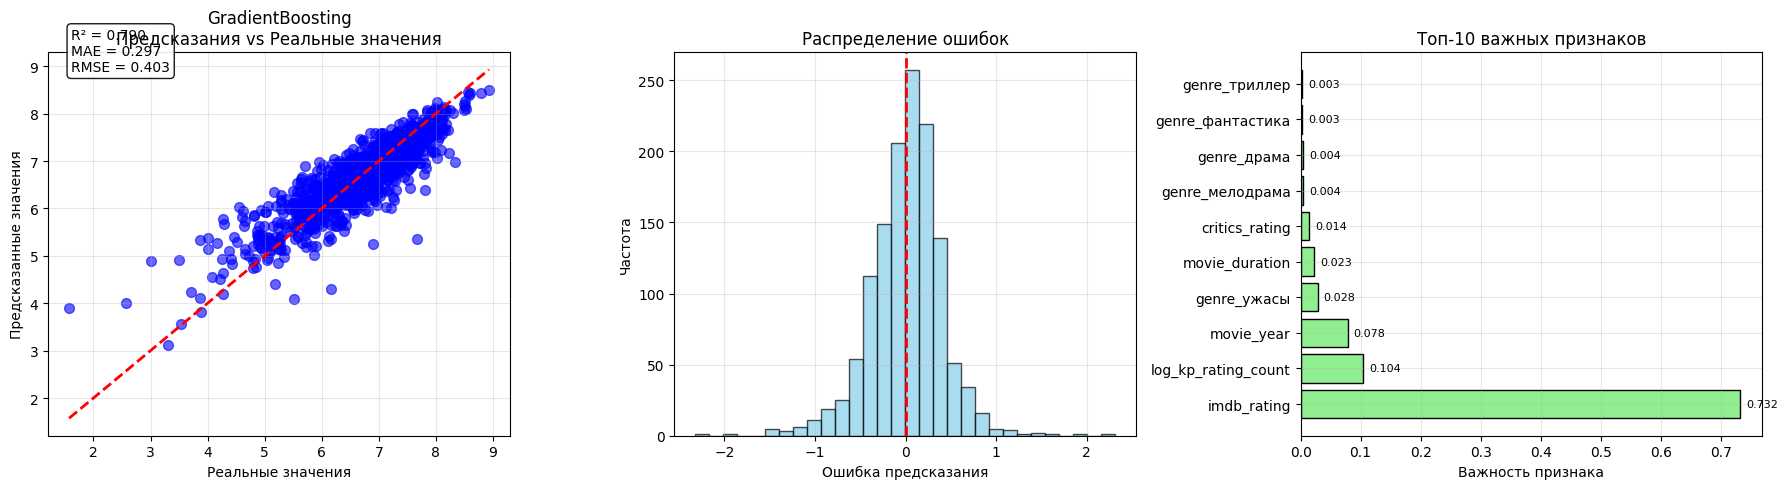


ФИНАЛЬНЫЙ ОТЧЕТ И ВЫВОДЫ
📈 СВОДНАЯ СТАТИСТИКА:
   - Всего моделей протестировано: 6
   - Переобученных моделей: 0

🎯 ЛУЧШАЯ МОДЕЛЬ: GradientBoosting
   - Test R²: 0.790
   - Test MAE: 0.297
   - Test RMSE: 0.403

🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
   1. Качество предсказаний: ВЫСОКОЕ
   2. Эффективность регуляризации: ВЫСОКАЯ

💡 РЕКОМЕНДАЦИИ:
   1. Качество модели удовлетворительное
   2. Можно использовать для прогнозирования
   3. Рассмотреть ансамблирование моделей


In [7]:
print("\n" + "=" * 60)
print("2.7. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ И ВЫВОДЫ")
print("=" * 60)

# Детальный анализ лучшей модели
if best_model_name:
    print(f"\n🎯 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    best_model = trained_models[best_model_name]
    y_test_pred_best = best_model.predict(X_test_scaled)
    
    # Детальная визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Предсказания vs Реальные значения
    axes[0].scatter(y_test, y_test_pred_best, alpha=0.6, s=50, color='blue')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0].set_xlabel('Реальные значения')
    axes[0].set_ylabel('Предсказанные значения')
    axes[0].set_title(f'{best_model_name}\nПредсказания vs Реальные значения')
    axes[0].grid(True, alpha=0.3)
    
    # Добавляем метрики
    test_r2_best = r2_score(y_test, y_test_pred_best)
    test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
    test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
    
    axes[0].text(0.05, 0.95, f'R² = {test_r2_best:.3f}\nMAE = {test_mae_best:.3f}\nRMSE = {test_rmse_best:.3f}', 
                transform=axes[0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
                fontsize=10)
    
    # 2. Распределение ошибок
    errors = y_test - y_test_pred_best
    axes[1].hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Ошибка предсказания')
    axes[1].set_ylabel('Частота')
    axes[1].set_title('Распределение ошибок')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Важность признаков
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        bars = axes[2].barh(feature_importance['feature'], feature_importance['importance'], 
                           color='lightgreen', edgecolor='black')
        axes[2].set_xlabel('Важность признака')
        axes[2].set_title('Топ-10 важных признаков')
        axes[2].grid(True, alpha=0.3)
        
        # Добавляем значения важности
        for bar in bars:
            width = bar.get_width()
            axes[2].text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                        f'{width:.3f}', ha='left', va='center', fontsize=8)
    else:
        axes[2].text(0.5, 0.5, 'Важность признаков\nне доступна\nдля этой модели', 
                    ha='center', va='center', transform=axes[2].transAxes, fontsize=12)
        axes[2].set_title('Важность признаков')
    
    plt.tight_layout()
    plt.show()

# Финальный отчет
print("\n" + "="*50)
print("ФИНАЛЬНЫЙ ОТЧЕТ И ВЫВОДЫ")
print("="*50)

print("📈 СВОДНАЯ СТАТИСТИКА:")
print(f"   - Всего моделей протестировано: {len(results_df)}")
print(f"   - Переобученных моделей: {results_df['is_overfit'].sum()}")

if best_model_name:
    best_final = final_results_df[final_results_df['model'] == best_model_name].iloc[0]
    
    print(f"\n🎯 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print(f"   - Test R²: {best_final['test_r2']:.3f}")
    print(f"   - Test MAE: {best_final['test_mae']:.3f}")
    print(f"   - Test RMSE: {best_final['test_rmse']:.3f}")

print(f"\n🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
if best_final['test_r2'] > 0.7:
    quality = "ВЫСОКОЕ"
elif best_final['test_r2'] > 0.5:
    quality = "СРЕДНЕЕ"
elif best_final['test_r2'] > 0.3:
    quality = "НИЗКОЕ"
else:
    quality = "ОЧЕНЬ НИЗКОЕ"

print(f"   1. Качество предсказаний: {quality}")
print(f"   2. Эффективность регуляризации: {'ВЫСОКАЯ' if results_df['is_overfit'].sum() == 0 else 'СРЕДНЯЯ'}")

print(f"\n💡 РЕКОМЕНДАЦИИ:")
if best_final['test_r2'] < 0.5:
    print("   1. Собрать больше данных")
    print("   2. Улучшить feature engineering") 
    print("   3. Добавить внешние данные")
else:
    print("   1. Качество модели удовлетворительное")
    print("   2. Можно использовать для прогнозирования")
    print("   3. Рассмотреть ансамблирование моделей")

Сохранение модели

In [8]:
print("\n" + "="*60)
print("СОХРАНЕНИЕ МОДЕЛИ ДЛЯ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ")
print("="*60)

def save_trained_model(best_model, scaler, feature_columns, file_path='trained_movie_model.pkl'):
    """Сохраняет обученную модель для использования в рекомендательной системе"""
    model_data = {
        'model': best_model,
        'scaler': scaler,
        'feature_columns': feature_columns,
        'model_type': best_model_name,
        'test_r2': best_final['test_r2'],
        'test_mae': best_final['test_mae'],
        'test_rmse': best_final['test_rmse']
    }
    
    with open(file_path, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"✅ Модель {best_model_name} сохранена в {file_path}")
    print(f"📊 Метрики модели: R²={best_final['test_r2']:.3f}, MAE={best_final['test_mae']:.3f}")
    return model_data

# Сохраняем лучшую модель после обучения
if best_model_name:
    model_data = save_trained_model(best_model, scaler, feature_columns)
    
    # Дополнительно сохраняем все модели
    all_models_data = {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'all_models': trained_models,
        'scaler': scaler,
        'feature_columns': feature_columns,
        'test_results': final_results_df,
        'feature_importance': feature_importance if 'feature_importance' in locals() else None
    }
    
    with open('all_trained_models.pkl', 'wb') as f:
        pickle.dump(all_models_data, f)
    print("✅ Все модели сохранены в all_trained_models.pkl")
    
    # Сохраняем информацию о данных для рекомендательной системы
    data_info = {
        'original_shape': df.shape,
        'processed_shape': df_processed.shape,
        'feature_names': feature_columns,
        'target_name': 'kp_rating',
        'data_preprocessing_info': 'Улучшенная предобработка с feature engineering'
    }
    
    with open('model_data_info.pkl', 'wb') as f:
        pickle.dump(data_info, f)
    print("✅ Информация о данных сохранена в model_data_info.pkl")

print("\n" + "="*50)
print("🎉 КУРСОВАЯ РАБОТА ЗАВЕРШЕНА!")
print("="*50)
print("📁 Сохраненные файлы:")
print("   - trained_movie_model.pkl (лучшая модель для рекомендательной системы)")
print("   - all_trained_models.pkl (все обученные модели)")
print("   - model_data_info.pkl (информация о данных)")
print("\n🚀 Теперь можно запускать рекомендательную систему!")


СОХРАНЕНИЕ МОДЕЛИ ДЛЯ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ
✅ Модель GradientBoosting сохранена в trained_movie_model.pkl
📊 Метрики модели: R²=0.790, MAE=0.297
✅ Все модели сохранены в all_trained_models.pkl
✅ Информация о данных сохранена в model_data_info.pkl

🎉 КУРСОВАЯ РАБОТА ЗАВЕРШЕНА!
📁 Сохраненные файлы:
   - trained_movie_model.pkl (лучшая модель для рекомендательной системы)
   - all_trained_models.pkl (все обученные модели)
   - model_data_info.pkl (информация о данных)

🚀 Теперь можно запускать рекомендательную систему!
